In [83]:
import os 
import numpy as np
import PIL 
from PIL import Image
import random
import matplotlib.pyplot as plt 


In [84]:
base_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
def file_path(base_dir):
    img_name =[]
    for file in os.listdir(base_dir):
        # Skip 'README.md' and 'data.csv'
        if file not in ['README.md', 'data.csv']:
            file_path = os.path.join(base_dir, file)
            # Check if it's a directory
            if os.path.isdir(file_path):
                for img in os.listdir(file_path):
                    # Check if 'mask' is in the filename
                    if 'mask' in img:
                        img_name.append(os.path.join(file_path,img))
    return img_name

In [85]:
imag_path = file_path(base_dir)

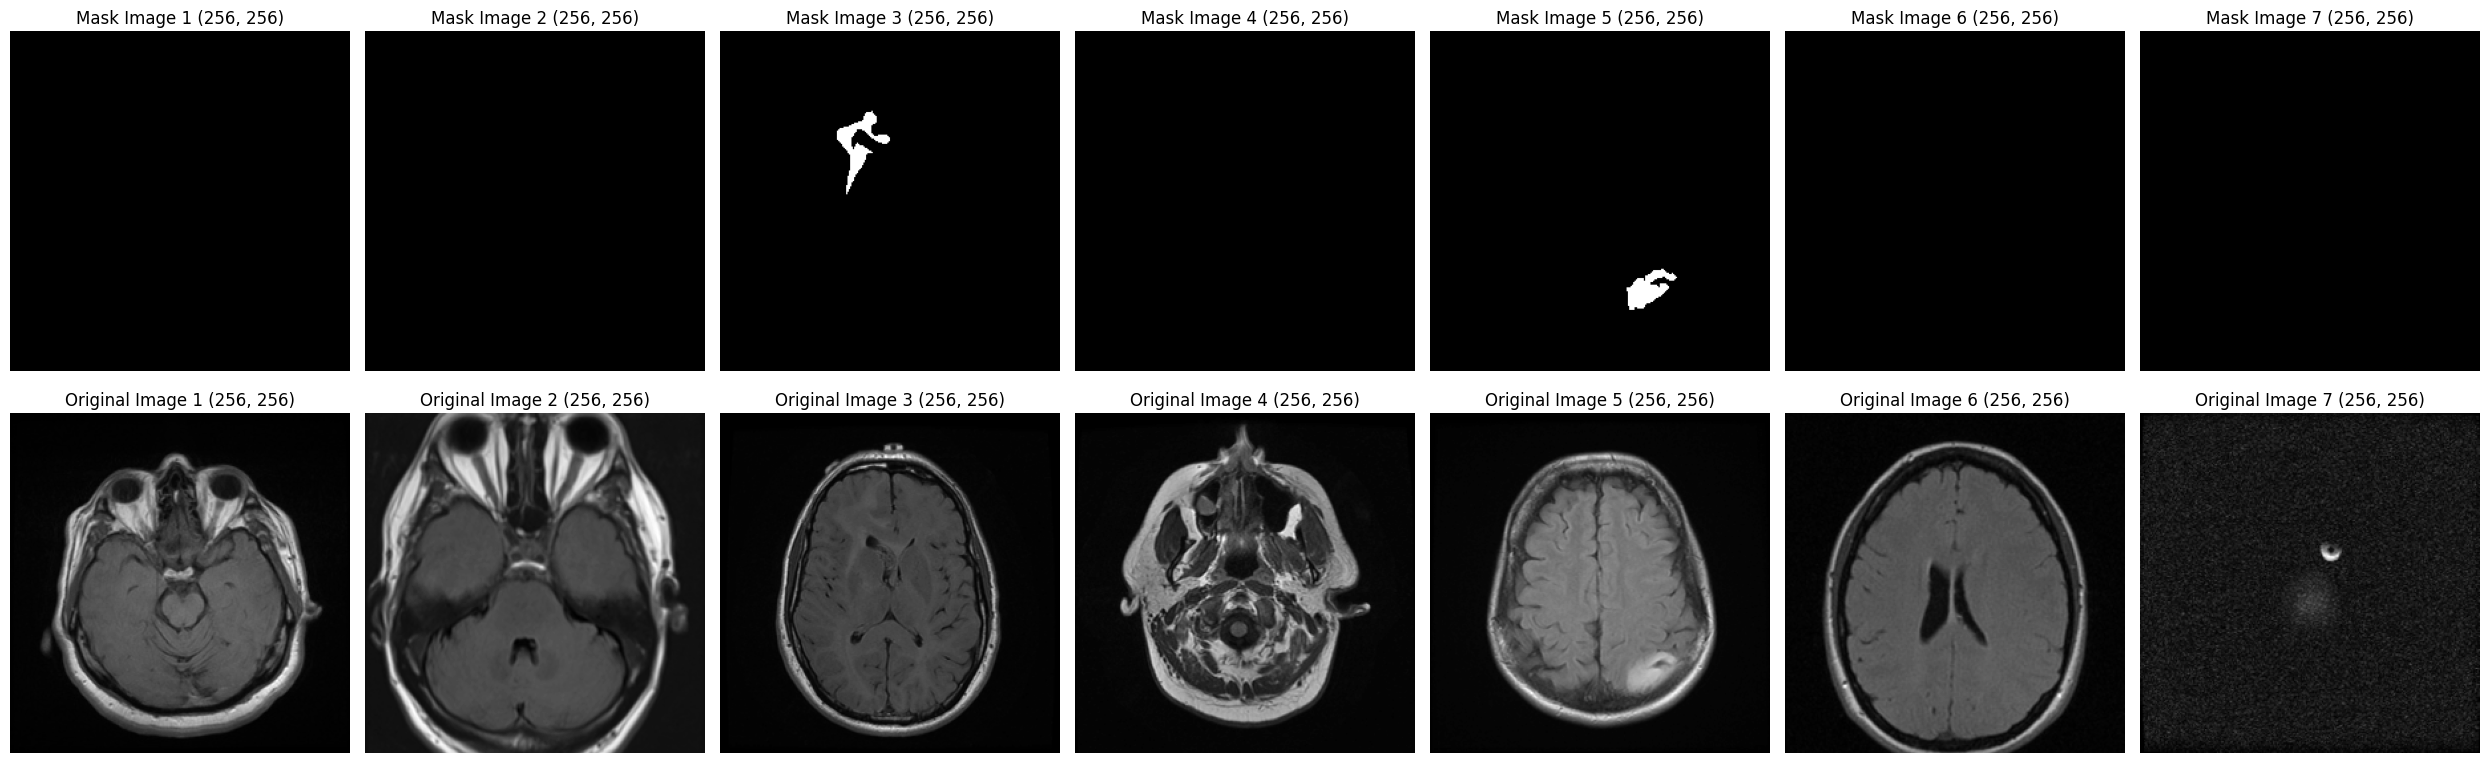

In [86]:
def plot_sample(image_path):
    fig, axs = plt.subplots(2, 7, figsize=(25, 8))
    img_sample = random.sample(image_path, 7) 
    
    for n, img in enumerate(img_sample):
        img_original = Image.open(img).convert('L')  
        img_replaced = img.replace("_mask.tif", ".tif")
        img_replaced_image = Image.open(img_replaced).convert('L') 
        
        axs[0, n].imshow(img_original, cmap='gray') 
        axs[0, n].set_title(f'Mask Image {n+1} {img_original.size}')
        axs[0, n].axis('off')
        
        axs[1, n].imshow(img_replaced_image, cmap='gray')
        axs[1, n].set_title(f'Original Image {n+1} {img_replaced_image.size}')
        axs[1, n].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample(imag_path)

In [87]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor
import torch.nn.functional as F
from torchvision import transforms
import time
from torch.utils.data import random_split
from sklearn.metrics import jaccard_score

In [88]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [89]:
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, feature_layers):
        super(VGG16FeatureExtractor, self).__init__()
        self.first = nn.Conv2d(1, 3, kernel_size=1)
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.features = nn.Sequential(*list(vgg16.features.children()))
        self.feature_layers = feature_layers

    def forward(self, x):
        x = self.first(x)
        features = []
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

In [90]:
class Unet(nn.Module):
    def __init__(self, out_channels, feature_layers, features=[64, 128, 256, 512]):
        super(Unet, self).__init__()
        self.feature_extractor = VGG16FeatureExtractor(feature_layers)
        
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        
        
        self.bottleneck = DoubleConv(512, 1024)
        
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_convs.append(DoubleConv(feature*2, feature))
            
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = self.feature_extractor(x)
        
        x = self.bottleneck(skip_connections[-1])
        
        skip_connections = skip_connections[::-1]  
        for idx in range(len(self.ups)):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear')
                
            x = torch.cat((skip_connection, x), dim=1)
            x = self.up_convs[idx](x)
        
        return self.final_conv(x)


In [91]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_path_mask, image_transform=None,mask_transform=None):
        self.image_path_mask = image_path_mask
        self.image_transform = image_transform
        self.mask_transform = mask_transform
    def __len__(self):
        return len(self.image_path_mask)

    def __getitem__(self, idx):

        img_path_mask = self.image_path_mask[idx]
        img_path = img_path_mask.replace("_mask.tif", ".tif")

        image = Image.open(img_path).convert('L')
        image_mask = Image.open(img_path_mask).convert('L')
        
        # image = transforms.Resize((128, 128))(image)  # Resize input image too
        # image_mask = transforms.Resize((128, 128))(image_mask)
        
        if self.image_transform :
            image = self.image_transform(image)
            
        if self.mask_transform :
            image_mask = self.mask_transform(image_mask)

        image_mask = transforms.Resize((128, 128))(image_mask)

        return image, image_mask


In [92]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
mask_transform = transforms.ToTensor()

full_dataset = CustomDataset(
    image_path_mask=imag_path,
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

In [93]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
    
    avg_loss = val_loss / total_samples
    
    return avg_loss,


In [107]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        
        val_loss = validate(model, val_loader, criterion, device)[0]
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
  
        print(f'Epoch: {epoch+1}/{num_epochs}  Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
    return history

In [145]:
model = Unet(out_channels=1, feature_layers=[4, 9, 16, 23]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 30
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=num_epochs
)

Epoch: 1/30  Train Loss: 0.2057 | Val Loss: 0.1037
Epoch: 2/30  Train Loss: 0.0757 | Val Loss: 0.0551
Epoch: 3/30  Train Loss: 0.0479 | Val Loss: 0.0400
Epoch: 4/30  Train Loss: 0.0354 | Val Loss: 0.0351
Epoch: 5/30  Train Loss: 0.0286 | Val Loss: 0.0299
Epoch: 6/30  Train Loss: 0.0233 | Val Loss: 0.0209
Epoch: 7/30  Train Loss: 0.0190 | Val Loss: 0.0164
Epoch: 8/30  Train Loss: 0.0163 | Val Loss: 0.0170
Epoch: 9/30  Train Loss: 0.0139 | Val Loss: 0.0123
Epoch: 10/30  Train Loss: 0.0127 | Val Loss: 0.0112
Epoch: 11/30  Train Loss: 0.0108 | Val Loss: 0.0101
Epoch: 12/30  Train Loss: 0.0093 | Val Loss: 0.0101
Epoch: 13/30  Train Loss: 0.0090 | Val Loss: 0.0131
Epoch: 14/30  Train Loss: 0.0085 | Val Loss: 0.0104
Epoch: 15/30  Train Loss: 0.0076 | Val Loss: 0.0086
Epoch: 16/30  Train Loss: 0.0070 | Val Loss: 0.0080
Epoch: 17/30  Train Loss: 0.0070 | Val Loss: 0.0080
Epoch: 18/30  Train Loss: 0.0068 | Val Loss: 0.0077
Epoch: 19/30  Train Loss: 0.0058 | Val Loss: 0.0075
Epoch: 20/30  Train L

KeyboardInterrupt: 

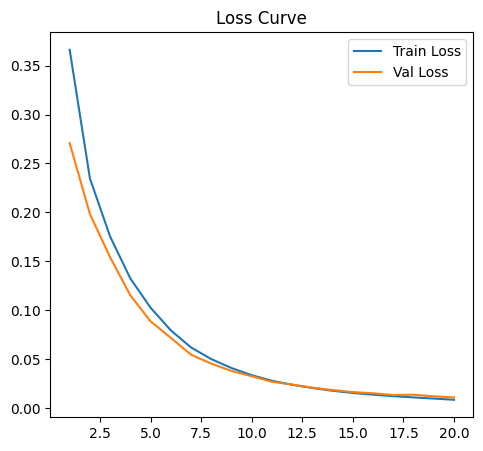

In [147]:
import matplotlib.pyplot as plt
np.arange(1,num_epochs+1,1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
x = np.arange(1,20+1,1)
plt.plot(x,history['train_loss'], label='Train Loss')
plt.plot(x,history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

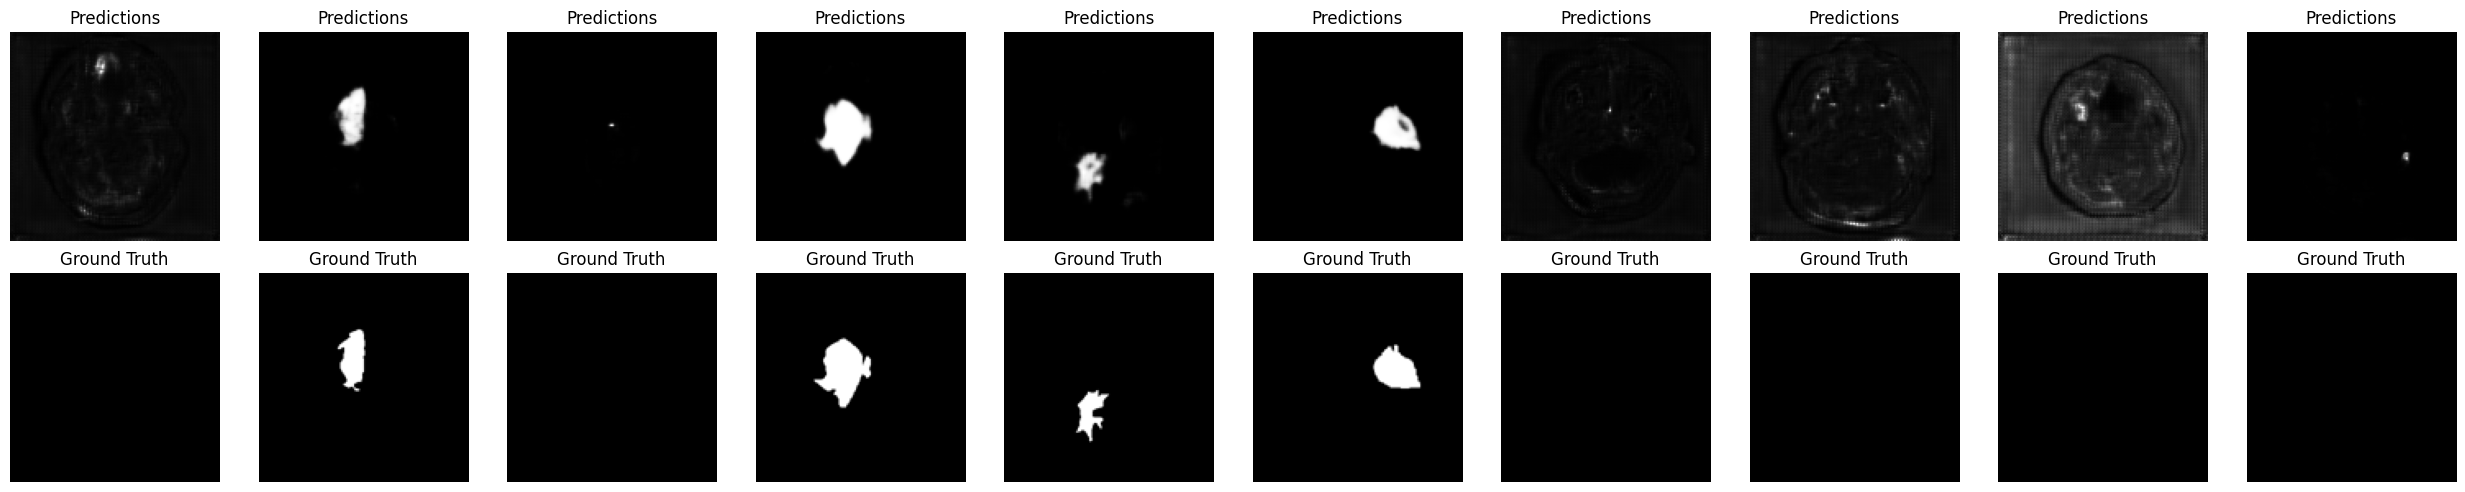

In [184]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

sample_indices = random.sample(range(len(imag_path)), 10)

fig, axes = plt.subplots(2, 10, figsize=(25, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

model.eval()

for i, idx in enumerate(sample_indices):
    img_path = imag_path[idx].replace("_mask.tif", ".tif")
    mask_path = imag_path[idx]
    
    image = Image.open(img_path).convert('L')
    mask = Image.open(mask_path).convert('L')
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
    pred = torch.sigmoid(output).squeeze().cpu().numpy()
    
    mask = mask.resize((pred.shape[1], pred.shape[0]))
    mask = np.array(mask) / 255.0  
    
    axes[0, i].imshow(pred, cmap='gray')
    axes[0, i].set_title('Predictions')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title('Ground Truth')
    axes[1, i].axis('off')
    



plt.tight_layout()
plt.show()